# Pipelines

## Extracción de Características: Vectorizer

Para algunos tipos de datos se debre realizar una extracción de características para convertirlos en características numéricas. En el ejemplo de **spam** por ejemplo.

In [29]:
import os

with open(os.path.join("datasets", "SMSSpamCollection.txt")) as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

text = [x[1] for x in lines]
y = [int(x[0] == "ham") for x in lines]

In [16]:
from sklearn.model_selection import train_test_split

text_train, text_test, y_train, y_test = train_test_split(text, y)

Anteriormente se han extraido las características de forma manual:

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizacion = TfidfVectorizer()
vectorizacion.fit(text_train);

In [36]:
X_train = vectorizacion.transform(text_train)
X_test = vectorizacion.transform(text_test)

In [37]:
X_train.shape

(4180, 7497)

In [38]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train);

In [39]:
lgr.score(X_test, y_test)

0.9684361549497847

La tarea de aprender una transformación y luego aplicarla a los datos de test es una tarea mouy común en Machine Learning. Por lo cual, scikit-learn implementa un método denominador **tuberias (pipelines)**.

In [40]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression())
pipeline.fit(text_train, y_train)
pipeline.score(text_test, y_test)

0.9684361549497847

Esto hace que sea mucho más fácil de trabajar. Cuando se ejecuta **fit** en la tubería, se llamará a cade método de forma sucesiva. Después del primer ajuste, se una **transform** para crear una nueva representación. Esta se usará como entrada en el método **fit** del siguiente paso, y así sucesivamente. En el último paso no se llama a **transform**.

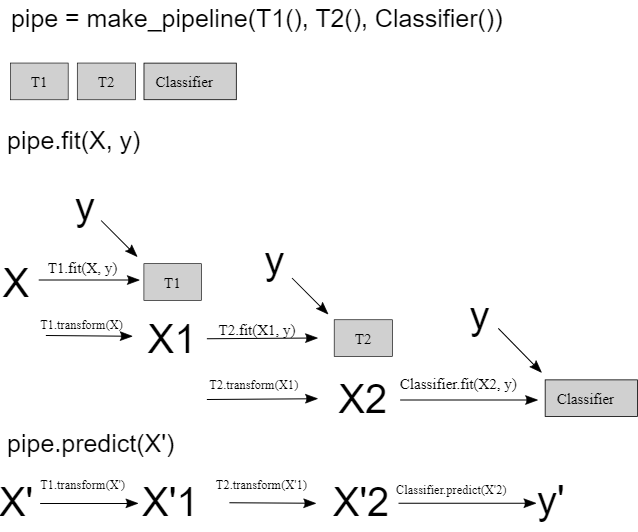

Si se usa **score**, se llamará a **transform** en cada paso, generando lo que serían los datos de test. Al final se aplicará **score** sobre la representación final obtenida (estos mismo pasos se harán para **predict**).

El uso de **pipelines** además de permitir simplificar el código, permite ajustar los parámetros. Por ejemplo, si se quisiera ajustar el parámetro $C$ de la regresión logística.

---

In [42]:
# Esto es un metodo erroneo
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import os

with open(os.path.join("datasets", "SMSSpamCollection.txt")) as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

text = [x[1] for x in lines]
y = [int(x[0] == "ham") for x in lines]

text_train, text_test, y_train, y_test = train_test_split(text, y)

vectorizacion = TfidfVectorizer()
vectorizacion.fit(text_train)

X_train = vectorizacion.transform(text_train)
X_test = vectorizacion.transform(text_test)

lgr = LogisticRegression(max_iter=1000)
grid = GridSearchCV(lgr, param_grid={'C': [.01, .1, 1, 10, 100]}, cv=5)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.9842180774748924

---

<div class="alert alert-success">
    Cuando se usó <b>TfidfVectorizer</b> se entrenó con el conjunto <b>X_train</b> completo, no solo con los folds de entrenamiento a diferencia de la búsqueda <b>grid</b> con validación cruzada. Por lo tanto, se podría estar usando conocimiento acerca de la frecuencia de las palabras en los folds de test. Esto se denomina <b>contaminación</b> del conjunto Test y lleva a estimaciones demasiado optimistas del rendimiento de generalización o a parámetros seleccionados de forma incorrecta.     
</div>

El código anterior se puede arreglar usando un Pipeline.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import os

with open(os.path.join("datasets", "SMSSpamCollection.txt")) as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

text = [x[1] for x in lines]
y = [int(x[0] == "ham") for x in lines]

text_train, text_test, y_train, y_test = train_test_split(text, y)

pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

grid = GridSearchCV(pipeline, param_grid={'logisticregression__C': [.01, .1, 1, 10, 100]}, cv=5)

grid.fit(text_train, y_train)
grid.score(text_test, y_test)

0.9892395982783357

Se debe indicar en que parte del pipeline aparece el parámetro $C$. Para esto se usa la sintaxis **__**. El nombre que antecede a **__** es el nombre de la clase en minúscula, la parte posterior es el parámetro a ajustar por la búsqueda **grid**.

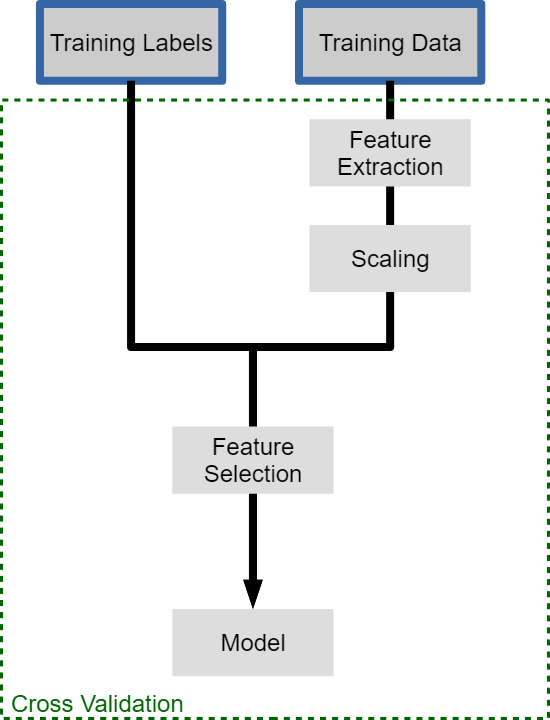

También es posible buscar los parámetro de los algoritmos de extracción de características mediante el uso de **GridSearchCV**.

In [46]:
from sklearn.model_selection import GridSearchCV

pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

params = {'logisticregression__C': [.1, 1, 10, 90, 100, 105],
          "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2)]}

grid = GridSearchCV(pipeline, param_grid=params, cv=5)
grid.fit(text_train, y_train)
print(grid.best_params_)
grid.score(text_test, y_test)

{'logisticregression__C': 90, 'tfidfvectorizer__ngram_range': (1, 2)}


0.990674318507891